# 包导入

In [1]:
# -*- coding: utf-8 -*-
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import time
import json
import logging
import scipy.io
import functools
import argparse
import warnings
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import torch
import torchvision
import torch._utils
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.nn import init
from torch2trt import torch2trt
from torch.autograd import Variable
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, models, transforms

from math import sqrt
from IPython import embed
from PIL import Image
from shutil import copyfile
from samplers import RandomIdentitySampler
from triplet_loss import TripletLoss, CrossEntropyLabelSmooth

BN_MOMENTUM = 0.1
matplotlib.use('agg')
cudnn.benchmark = True
cudnn.deterministic = True
writer = SummaryWriter('log')
version =  torch.__version__
warnings.filterwarnings('ignore')
logger = logging.getLogger(__name__)

# HRNet-reID 网络定义

In [2]:
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv2d') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
        init.constant(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
    elif classname.find('BatchNorm1d') != -1:
        init.normal(m.weight.data, 1.0, 0.02)
        init.constant(m.bias.data, 0.0)

def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.normal(m.weight.data, std=0.001)


def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

# Defines the new fc layer and classification layer
# |--Linear--|--bn--|--relu--|--Linear--|
class ClassBlock(nn.Module):
    def __init__(self, input_dim, class_num, droprate, relu=False, bnorm=True, num_bottleneck=512, linear=True, return_f = False):
        super(ClassBlock, self).__init__()
        self.return_f = return_f
        add_block = []
        if linear:
            add_block += [nn.Linear(input_dim, num_bottleneck)]
        else:
            num_bottleneck = input_dim
        if bnorm:
            add_block += [nn.BatchNorm1d(num_bottleneck)]
        if relu:
            add_block += [nn.LeakyReLU(0.1)]
        if droprate>0:
            add_block += [nn.Dropout(p=droprate)]
        add_block = nn.Sequential(*add_block)
        add_block.apply(weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(num_bottleneck, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(weights_init_classifier)

        self.add_block = add_block
        self.classifier = classifier
    def forward(self, x):
        x = self.add_block(x)
        if self.return_f:
            f = x
            x = self.classifier(x)
            return x,f
        else:
            x = self.classifier(x)
            return x
#######################################################################        
#空间注意力机制
#-----------------------------------------

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)
 #######################################################################        
#通道注意力机制
#-----------------------------------------   
    
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)

        self.fc1   = nn.Conv2d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv2d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)
#######################################################################        
#HRNet
#-----------------------------------------

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes, momentum=BN_MOMENTUM)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion,
                               momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class HighResolutionModule(nn.Module):
    def __init__(self, num_branches, blocks, num_blocks, num_inchannels,
                 num_channels, fuse_method, multi_scale_output=True):
        super(HighResolutionModule, self).__init__()
        self._check_branches(
            num_branches, blocks, num_blocks, num_inchannels, num_channels)

        self.num_inchannels = num_inchannels
        self.fuse_method = fuse_method
        self.num_branches = num_branches

        self.multi_scale_output = multi_scale_output

        self.branches = self._make_branches(
            num_branches, blocks, num_blocks, num_channels)
        self.fuse_layers = self._make_fuse_layers()
        self.relu = nn.ReLU(False)

    def _check_branches(self, num_branches, blocks, num_blocks,
                        num_inchannels, num_channels):
        if num_branches != len(num_blocks):
            error_msg = 'NUM_BRANCHES({}) <> NUM_BLOCKS({})'.format(
                num_branches, len(num_blocks))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_channels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_CHANNELS({})'.format(
                num_branches, len(num_channels))
            logger.error(error_msg)
            raise ValueError(error_msg)

        if num_branches != len(num_inchannels):
            error_msg = 'NUM_BRANCHES({}) <> NUM_INCHANNELS({})'.format(
                num_branches, len(num_inchannels))
            logger.error(error_msg)
            raise ValueError(error_msg)

    def _make_one_branch(self, branch_index, block, num_blocks, num_channels,
                         stride=1):
        downsample = None
        if stride != 1 or \
           self.num_inchannels[branch_index] != num_channels[branch_index] * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.num_inchannels[branch_index],
                          num_channels[branch_index] * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(num_channels[branch_index] * block.expansion,
                            momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(self.num_inchannels[branch_index],
                            num_channels[branch_index], stride, downsample))
        self.num_inchannels[branch_index] = \
            num_channels[branch_index] * block.expansion
        for i in range(1, num_blocks[branch_index]):
            layers.append(block(self.num_inchannels[branch_index],
                                num_channels[branch_index]))

        return nn.Sequential(*layers)

    def _make_branches(self, num_branches, block, num_blocks, num_channels):
        branches = []

        for i in range(num_branches):
            branches.append(
                self._make_one_branch(i, block, num_blocks, num_channels))

        return nn.ModuleList(branches)

    def _make_fuse_layers(self):
        if self.num_branches == 1:
            return None

        num_branches = self.num_branches
        num_inchannels = self.num_inchannels
        fuse_layers = []
        for i in range(num_branches if self.multi_scale_output else 1):
            fuse_layer = []
            for j in range(num_branches):
                if j > i:
                    fuse_layer.append(nn.Sequential(
                        nn.Conv2d(num_inchannels[j],
                                  num_inchannels[i],
                                  1,
                                  1,
                                  0,
                                  bias=False),
                        nn.BatchNorm2d(num_inchannels[i], 
                                       momentum=BN_MOMENTUM),
                        nn.Upsample(scale_factor=2**(j-i), mode='nearest')))
                elif j == i:
                    fuse_layer.append(None)
                else:
                    conv3x3s = []
                    for k in range(i-j):
                        if k == i - j - 1:
                            num_outchannels_conv3x3 = num_inchannels[i]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                nn.BatchNorm2d(num_outchannels_conv3x3, 
                                            momentum=BN_MOMENTUM)))
                        else:
                            num_outchannels_conv3x3 = num_inchannels[j]
                            conv3x3s.append(nn.Sequential(
                                nn.Conv2d(num_inchannels[j],
                                          num_outchannels_conv3x3,
                                          3, 2, 1, bias=False),
                                nn.BatchNorm2d(num_outchannels_conv3x3,
                                            momentum=BN_MOMENTUM),
                                nn.ReLU(False)))
                    fuse_layer.append(nn.Sequential(*conv3x3s))
            fuse_layers.append(nn.ModuleList(fuse_layer))

        return nn.ModuleList(fuse_layers)

    def get_num_inchannels(self):
        return self.num_inchannels

    def forward(self, x):
        if self.num_branches == 1:
            return [self.branches[0](x[0])]

        for i in range(self.num_branches):
            x[i] = self.branches[i](x[i])

        x_fuse = []
        for i in range(len(self.fuse_layers)):
            y = x[0] if i == 0 else self.fuse_layers[i][0](x[0])
            for j in range(1, self.num_branches):
                if i == j:
                    y = y + x[j]
                else:
                    y = y + self.fuse_layers[i][j](x[j])
            x_fuse.append(self.relu(y))

        return x_fuse


blocks_dict = {
    'BASIC': BasicBlock,
    'BOTTLENECK': Bottleneck
}


class HighResolutionNet(nn.Module):

    def __init__(self, cl, cfg, **kwargs):
        super(HighResolutionNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(64, momentum=BN_MOMENTUM)
        self.relu = nn.ReLU(inplace=True)

        self.stage1_cfg = cfg['MODEL']['EXTRA']['STAGE1']
        num_channels = self.stage1_cfg['NUM_CHANNELS'][0]
        block = blocks_dict[self.stage1_cfg['BLOCK']]
        num_blocks = self.stage1_cfg['NUM_BLOCKS'][0]
        self.layer1 = self._make_layer(block, 64, num_channels, num_blocks)
        stage1_out_channel = block.expansion*num_channels

        self.stage2_cfg = cfg['MODEL']['EXTRA']['STAGE2']
        num_channels = self.stage2_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage2_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition1 = self._make_transition_layer(
            [stage1_out_channel], num_channels)
        self.stage2, pre_stage_channels = self._make_stage(
            self.stage2_cfg, num_channels)

        self.stage3_cfg = cfg['MODEL']['EXTRA']['STAGE3']
        num_channels = self.stage3_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage3_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition2 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage3, pre_stage_channels = self._make_stage(
            self.stage3_cfg, num_channels)

        self.stage4_cfg = cfg['MODEL']['EXTRA']['STAGE4']
        num_channels = self.stage4_cfg['NUM_CHANNELS']
        block = blocks_dict[self.stage4_cfg['BLOCK']]
        num_channels = [
            num_channels[i] * block.expansion for i in range(len(num_channels))]
        self.transition3 = self._make_transition_layer(
            pre_stage_channels, num_channels)
        self.stage4, pre_stage_channels = self._make_stage(
            self.stage4_cfg, num_channels, multi_scale_output=True)

        # Classification Head
        self.incre_modules, self.downsamp_modules, \
            self.final_layer = self._make_head(pre_stage_channels)
        
        #addition
        
        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )
        
        self.fc_loc = nn.Sequential(
            nn.Linear(16800,512),
            nn.ReLU(True),
            nn.Linear(512,2*3)
        )

        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1,0,0,0,1,0],dtype=torch.float))
        
        self.SA = SpatialAttention()
        self.CAi = ChannelAttention(in_planes=64)
        self.CAo1 = ChannelAttention(in_planes=128)
        self.CAo2 = ChannelAttention(in_planes=256)
        self.CAo3 = ChannelAttention(in_planes=512)
        self.CAo4 = ChannelAttention(in_planes=1024)
        self.avgpool_1 = nn.AdaptiveAvgPool2d((1,1))
        self.maxpool_1 = nn.AdaptiveMaxPool2d((1,1))
        self.avgpool_2 = nn.AdaptiveAvgPool2d((2,2))
        self.maxpool_2 = nn.AdaptiveMaxPool2d((2,2))
        self.avgpool_3 = nn.AdaptiveAvgPool2d((3,3))
        self.maxpool_3 = nn.AdaptiveMaxPool2d((3,3))
        self.avgpool_4 = nn.AdaptiveAvgPool2d((4,4))
        self.maxpool_4 = nn.AdaptiveMaxPool2d((4,4))
        self.classifier = ClassBlock(6144, 751, 0.5)
        self.cl = cl
    
    # STN froward
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 16800)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)
        grid = F.affine_grid(theta, x.size(), align_corners=False)
        x = F.grid_sample(x, grid, align_corners=False)
        return x
    
    def _make_head(self, pre_stage_channels):
        head_block = Bottleneck
        head_channels = [32, 64, 128, 256]

        # Increasing the #channels on each resolution 
        # from C, 2C, 4C, 8C to 128, 256, 512, 1024
        incre_modules = []
        for i, channels  in enumerate(pre_stage_channels):
            incre_module = self._make_layer(head_block,
                                            channels,
                                            head_channels[i],
                                            1,
                                            stride=1)
            incre_modules.append(incre_module)
        incre_modules = nn.ModuleList(incre_modules)
            
        # downsampling modules
        downsamp_modules = []
        for i in range(len(pre_stage_channels)-1):
            in_channels = head_channels[i] * head_block.expansion
            out_channels = head_channels[i+1] * head_block.expansion

            downsamp_module = nn.Sequential(
                nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels,
                          kernel_size=3,
                          stride=2,
                          padding=1),
                nn.BatchNorm2d(out_channels, momentum=BN_MOMENTUM),
                nn.ReLU(inplace=True)
            )

            downsamp_modules.append(downsamp_module)
        downsamp_modules = nn.ModuleList(downsamp_modules)

        final_layer = nn.Sequential(
            nn.Conv2d(
                in_channels=head_channels[3] * head_block.expansion,
                out_channels=2048,
                kernel_size=1,
                stride=1,
                padding=0
            ),
            nn.BatchNorm2d(2048, momentum=BN_MOMENTUM),
            nn.ReLU(inplace=True)
        )

        return incre_modules, downsamp_modules, final_layer

    def _make_transition_layer(
            self, num_channels_pre_layer, num_channels_cur_layer):
        num_branches_cur = len(num_channels_cur_layer)
        num_branches_pre = len(num_channels_pre_layer)

        transition_layers = []
        for i in range(num_branches_cur):
            if i < num_branches_pre:
                if num_channels_cur_layer[i] != num_channels_pre_layer[i]:
                    transition_layers.append(nn.Sequential(
                        nn.Conv2d(num_channels_pre_layer[i],
                                  num_channels_cur_layer[i],
                                  3,
                                  1,
                                  1,
                                  bias=False),
                        nn.BatchNorm2d(
                            num_channels_cur_layer[i], momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                else:
                    transition_layers.append(None)
            else:
                conv3x3s = []
                for j in range(i+1-num_branches_pre):
                    inchannels = num_channels_pre_layer[-1]
                    outchannels = num_channels_cur_layer[i] \
                        if j == i-num_branches_pre else inchannels
                    conv3x3s.append(nn.Sequential(
                        nn.Conv2d(
                            inchannels, outchannels, 3, 2, 1, bias=False),
                        nn.BatchNorm2d(outchannels, momentum=BN_MOMENTUM),
                        nn.ReLU(inplace=True)))
                transition_layers.append(nn.Sequential(*conv3x3s))

        return nn.ModuleList(transition_layers)

    def _make_layer(self, block, inplanes, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion, momentum=BN_MOMENTUM),
            )

        layers = []
        layers.append(block(inplanes, planes, stride, downsample))
        inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(inplanes, planes))

        return nn.Sequential(*layers)

    def _make_stage(self, layer_config, num_inchannels,
                    multi_scale_output=True):
        num_modules = layer_config['NUM_MODULES']
        num_branches = layer_config['NUM_BRANCHES']
        num_blocks = layer_config['NUM_BLOCKS']
        num_channels = layer_config['NUM_CHANNELS']
        block = blocks_dict[layer_config['BLOCK']]
        fuse_method = layer_config['FUSE_METHOD']

        modules = []
        for i in range(num_modules):
            # multi_scale_output is only used last module
            if not multi_scale_output and i == num_modules - 1:
                reset_multi_scale_output = False
            else:
                reset_multi_scale_output = True

            modules.append(
                HighResolutionModule(num_branches,
                                      block,
                                      num_blocks,
                                      num_inchannels,
                                      num_channels,
                                      fuse_method,
                                      reset_multi_scale_output)
            )
            num_inchannels = modules[-1].get_num_inchannels()

        return nn.Sequential(*modules), num_inchannels

    def forward(self, x):
        #x = self.stn(x)

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        
        x = self.CAi(x) * x
        x = self.SA(x) * x
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        
        x = self.CAi(x) * x
        x = self.SA(x) * x
        
        x = self.layer1(x)

        x_list = []
        for i in range(self.stage2_cfg['NUM_BRANCHES']):
            if self.transition1[i] is not None:
                x_list.append(self.transition1[i](x))
            else:
                x_list.append(x)
        y_list_s2 = self.stage2(x_list)
        
        x_list = []
        for i in range(self.stage3_cfg['NUM_BRANCHES']):
            if self.transition2[i] is not None:
                x_list.append(self.transition2[i](y_list_s2[-1]))
            else:
                x_list.append(y_list_s2[i])
        y_list_s3 = self.stage3(x_list)
        
        x_list = []
        for i in range(self.stage4_cfg['NUM_BRANCHES']):
            if self.transition3[i] is not None:
                x_list.append(self.transition3[i](y_list_s3[-1]))
            else:
                x_list.append(y_list_s3[i])       
        y_list = self.stage4(x_list)
        
        for i in range(4):
            y_list[i] = self.incre_modules[i](y_list[i])
        
        #y_list[0] = self.CAo1(y_list[0]) * y_list[0]
        #y_list[1] = self.CAo2(y_list[1]) * y_list[1]
        #y_list[2] = self.CAo3(y_list[2]) * y_list[2]
        #y_list[3] = self.CAo4(y_list[3]) * y_list[3]
        
        #for i in range(4):
        #    print(y_list[i].shape)
            
        y_list[0] = self.avgpool_4(y_list[0]) + 0.5*self.maxpool_4(y_list[0])
        y_list[1] = self.avgpool_2(y_list[1]) + 0.2*self.maxpool_2(y_list[1])
        y_list[2] = self.avgpool_2(y_list[2]) + 0.2*self.maxpool_2(y_list[2])
        y_list[3] = self.avgpool_1(y_list[3]) + 0.2*self.maxpool_1(y_list[3])
        
        #for i in range(4):
        #    print(y_list[i].shape)
        
        y_list[0] = y_list[0].view((y_list[0].shape)[0],-1)
        y_list[1] = y_list[1].view((y_list[1].shape)[0],-1)
        y_list[2] = y_list[2].view((y_list[2].shape)[0],-1)
        y_list[3] = y_list[3].view((y_list[3].shape)[0],-1)
        
        y_tlp = torch.cat((y_list[0],y_list[1],y_list[2],y_list[3]),1)
        y_cls = self.classifier(y_tlp)
        
        if self.cl:
            return y_tlp,y_list[0],y_list[1],y_list[2],y_list[3],y_cls
        self.classifier.classifier = nn.Sequential()
        y_cls_ft = self.classifier(y_tlp)
        return torch.cat((y_tlp,y_cls_ft),1)
    
    def init_weights(self, pretrained='',):
        logger.info('=> init weights from normal distribution')
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
        if os.path.isfile(pretrained):
            pretrained_dict = torch.load(pretrained)
            logger.info('=> loading pretrained model {}'.format(pretrained))
            model_dict = self.state_dict()
            pretrained_dict = {k: v for k, v in pretrained_dict.items()
                               if k in model_dict.keys()}
            for k, _ in pretrained_dict.items():
                logger.info(
                    '=> loading {} pretrained model {}'.format(k, pretrained))
            model_dict.update(pretrained_dict)
            self.load_state_dict(model_dict)

In [3]:
def get_cls_net(cl ,config, **kwargs):
    model = HighResolutionNet(cl, config, **kwargs)
    model.init_weights('hrnetv2_w32_imagenet_pretrained.pth')
    return model

In [4]:
# 网络初始化
from config import config
config.defrost()
config.merge_from_file(r'cls_hrnet_w32_sgd_lr5e-2_wd1e-4_bs32_x100.yaml')
config.freeze()

In [5]:
# TensorRT推理加速对比测试
dump_input = torch.zeros((1, 3, 256, 128)).cuda()
demo = get_cls_net(False,config)
demo = demo.eval()
demo = demo.cuda()
#demo_TensorRT = torch2trt(demo, [dump_input])
#demo_TensorRT = demo_TensorRT.eval()
#demo_TensorRT = demo_TensorRT.cuda()

start_time1 = time.time()
for i in range(1):
    out = demo(dump_input)
print(f'Torch {time.time()-start_time1}s')
print(out)

#start_time2 = time.time()
#for i in range(1):
#    out = demo_TensorRT(dump_input)
#print(f'TRT {time.time()-start_time2}s')
#print(out)

#with SummaryWriter(comment='HRNet-reID') as w:
#    w.add_graph(demo, (dump_input,))
# tensorboard --logdir=runs  

Torch 3.3534719944000244s
tensor([[ 0.0405,  0.0000,  0.0000,  ..., -0.0647, -0.0387, -0.0411]],
       device='cuda:0', grad_fn=<CatBackward0>)


# 训练

In [6]:
######################################################################
# 参数设置
# --------
gpu_ids = '0'
name = 'ft_net'
data_dir = r'market1501\pytorch'
train_all_1 = 'True'
batchsize = 32 
color_jitter = True
str_ids = gpu_ids.split(',')
gpu_ids = []
if not os.path.exists('./model/%s' % name):
        os.makedirs('./model/%s' % name)
for str_id in str_ids:
    gid = int(str_id)
    if gid >=0:
        gpu_ids.append(gid)

# set gpu ids
if len(gpu_ids)>0:
    torch.cuda.set_device(gpu_ids[0])
print('当前使用GPU-'+str(gpu_ids[0])+'进行训练')

######################################################################
# 数据加载
# ---------
transform_train_list = [
        transforms.Resize([256, 128]),
        transforms.RandomHorizontalFlip(0.5),
        #transforms.Pad(10),
        transforms.RandomCrop([256, 128]),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]

if color_jitter:
    transform_train_list = [transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0)] + transform_train_list

    print(transform_train_list)
data_transforms = {
    'train': transforms.Compose( transform_train_list )
}

train_all = ''
if train_all_1:
     train_all = '_all'

image_datasets = {}
image_datasets['train'] = datasets.ImageFolder(os.path.join(data_dir, 'train' + train_all),
                                          data_transforms['train'])


dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= batchsize,
                                              sampler= RandomIdentitySampler(image_datasets[x],batchsize,4), num_workers=0) # more workers may cause issues
              for x in ['train']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

since = time.time()
inputs, classes = next(iter(dataloaders['train']))
print(time.time()-since)

######################################################################
# 训练函数
# ------------------
y_loss = {} # loss history
y_loss['train'] = []
y_loss['val'] = []
y_err = {}
y_err['train'] = []
y_err['val'] = []

def train_model(model, criterion,triplet, num_epochs, epoch):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    while epoch < num_epochs:
        epoch = epoch +1
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        # update learning rat
        xx = (epoch//30)
        lr = 0.0085*pow(0.1,xx)
        optimizer = optim.SGD(model.parameters(), lr = lr,weight_decay=5e-4,momentum=0.9, nesterov=True)
        print(lr)
        for param_group in optimizer.param_groups:
        	param_group['lr'] = lr
        # Each epoch has a training and validation phase
        for phase in ['train']:
            if phase == 'train':
                #scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_loss_tlp = 0.0
            running_loss_Seq1 = 0.0
            running_loss_Seq2 = 0.0
            running_loss_Seq3 = 0.0
            running_loss_Seq4 = 0.0
            running_loss_Seq5 = 0.0
            running_loss_cls = 0.0
            running_corrects = 0.0
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                now_batch_size,c,h,w = inputs.shape
                if now_batch_size<batchsize: # skip the last batch
                    continue
                # wrap them in Variable
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                    #embed()
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                temp_loss = []
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                outputs= model(inputs)
                
                _, preds = torch.max(outputs[5].data, 1)
                loss_cls = criterion(outputs[5], labels)
                #loss2 = triplet(outputs[0], labels)[0]
                loss3 = triplet(outputs[1], labels)[0]
                loss4 = triplet(outputs[2], labels)[0]
                loss5 = triplet(outputs[3], labels)[0]
                loss6 = triplet(outputs[4], labels)[0]
                
                loss_tlp = (loss3+loss4+loss5+loss6)/4
                loss = loss_cls + loss_tlp
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                #running_loss_Seq1 += loss2.item() * now_batch_size
                running_loss_Seq2 += loss3.item() * now_batch_size
                running_loss_Seq3 += loss4.item() * now_batch_size
                running_loss_Seq4 += loss5.item() * now_batch_size
                running_loss_Seq5 += loss6.item() * now_batch_size
                running_loss_tlp += loss_tlp.item() * now_batch_size
                running_loss_cls += loss_cls.item() * now_batch_size
                running_loss += loss.item() * now_batch_size
                a = float((torch.sum((preds == labels.data))).item())
                running_corrects_1 = a 
                running_corrects_2 = running_corrects_1
                running_corrects +=running_corrects_2
            
            epoch_loss_tlp = running_loss_tlp / dataset_sizes[phase]
            #epoch_loss_Seq1 = running_loss_Seq1 / dataset_sizes[phase]
            epoch_loss_Seq2 = running_loss_Seq2 / dataset_sizes[phase]
            epoch_loss_Seq3 = running_loss_Seq3 / dataset_sizes[phase]
            epoch_loss_Seq4 = running_loss_Seq4 / dataset_sizes[phase]
            epoch_loss_Seq5 = running_loss_Seq5 / dataset_sizes[phase]
            epoch_loss_cls = running_loss_cls / dataset_sizes[phase]
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
             # 在日志文件中记录每个epoch的精度和loss
            with open('./model/%s/%s.txt' %(name,name),'a') as acc_file:
                acc_file.write('Epoch: %2d, csl_Precision: %.8f, Loss: %.8f\n' % (epoch, epoch_acc, epoch_loss))
            print('{} Loss: {:.4f} cls_acc: {:.7f}'.format(phase, epoch_loss, epoch_acc))
            
            writer.add_scalar('HRNet-reID train loss', epoch_loss, epoch)
            writer.add_scalar('HRNet-reID train accuracy', epoch_acc, epoch)
            writer.add_scalar('Cross Entropy loss', epoch_loss_cls, epoch)
            writer.add_scalars('TripletHard loss', {'Seq-1':epoch_loss_Seq2,
                                                    'Seq-2':epoch_loss_Seq3,
                                                    'Seq-3':epoch_loss_Seq4,
                                                    'Seq-4':epoch_loss_Seq5}, epoch)
            # tensorboard --logdir=./log 查看记录
            
            y_loss[phase].append(epoch_loss)
            y_err[phase].append(1.0-epoch_acc)            
            # deep copy the model
            if phase == 'train':
                last_model_wts = model.state_dict()
                if epoch < 150:
                    # 每5个epoch保存一次网络
                     if epoch%5 == 0:
                         save_network(model, epoch)
                     draw_curve(epoch)
                else:
                    save_network(model, epoch)
                    draw_curve(epoch)
                    
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print()
        
    writer.close()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    # load best model weights
    model.load_state_dict(last_model_wts)
    save_network(model, 'last')
    return model

######################################################################
# 绘图函数
#---------------------------
x_epoch = []
fig = plt.figure(figsize=(32,16))
ax0 = fig.add_subplot(121, title="loss")
ax1 = fig.add_subplot(122, title="top1err")
def draw_curve(current_epoch):
    x_epoch.append(current_epoch)
    ax0.plot(x_epoch, y_loss['train'], 'bo-', label='train')
    #ax0.plot(x_epoch, y_loss['val'], 'ro-', label='val')
    ax1.plot(x_epoch, y_err['train'], 'bo-', label='train')
    #ax1.plot(x_epoch, y_err['val'], 'ro-', label='val')
    if current_epoch == 0:
        ax0.legend()
        ax1.legend()
    fig.savefig( os.path.join('./model',name,'train.jpg'))

######################################################################
# 模型保存
#---------------------------
def save_network(network, epoch_label):
    save_filename = 'net_%s.pth'% epoch_label
    save_path = os.path.join('./model',name,save_filename)
    torch.save(network.cpu().state_dict(), save_path)
    if torch.cuda.is_available():
        network.cuda(gpu_ids[0])

######################################################################
# 损失函数
# ----------------------
triplet = TripletLoss(margin=0.3)
criterion = CrossEntropyLabelSmooth(num_classes=len(class_names))

当前使用GPU-0进行训练
[ColorJitter(brightness=[0.9, 1.1], contrast=[0.9, 1.1], saturation=[0.9, 1.1], hue=None), Resize(size=[256, 128], interpolation=bilinear, max_size=None, antialias=None), RandomHorizontalFlip(p=0.5), RandomCrop(size=(256, 128), padding=None), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
0.07851529121398926


In [7]:
######################################################################
# Def ftnet 从头开始
# ----------------------
use_gpu = 1
hrnet_train = get_cls_net(True, config)
model = hrnet_train

if use_gpu:
    model = model.cuda()

model = train_model(model, criterion, triplet,num_epochs=71, epoch=0)

Epoch 1/70
----------
0.0085
train Loss: 4.9805 cls_acc: 0.1516698
Training complete in 2m 28s

Epoch 2/70
----------
0.0085
train Loss: 3.3519 cls_acc: 0.3850495
Training complete in 4m 52s

Epoch 3/70
----------
0.0085
train Loss: 2.4611 cls_acc: 0.5845702
Training complete in 7m 17s

Epoch 4/70
----------
0.0085
train Loss: 2.0045 cls_acc: 0.6958101
Training complete in 9m 41s

Epoch 5/70
----------
0.0085
train Loss: 1.7555 cls_acc: 0.7589672
Training complete in 12m 6s

Epoch 6/70
----------
0.0085
train Loss: 1.5991 cls_acc: 0.8088281
Training complete in 14m 31s

Epoch 7/70
----------
0.0085
train Loss: 1.4555 cls_acc: 0.8491033
Training complete in 16m 56s

Epoch 8/70
----------
0.0085
train Loss: 1.3736 cls_acc: 0.8680427
Training complete in 19m 21s

Epoch 9/70
----------
0.0085
train Loss: 1.3263 cls_acc: 0.8715213
Training complete in 21m 45s

Epoch 10/70
----------
0.0085
train Loss: 1.2802 cls_acc: 0.8880643
Training complete in 24m 10s

Epoch 11/70
----------
0.0085
trai

In [5]:
######################################################################
# Def ftnet 权重加载
# ----------------------
load_epoch = 55 
name = 'ft_net'
use_gpu = 1

def load_network(network):
    save_path = os.path.join('./model',name,'net_%s.pth'%load_epoch)
    network.load_state_dict(torch.load(save_path))
    return network

hrnet_train = get_cls_net(True, config)
model = hrnet_train
model = load_network(model)

if use_gpu:
    model = model.cuda()

model = train_model(model, criterion, triplet,num_epochs=76, epoch=load_epoch)

C:\Users\geyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:28: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
C:\Users\geyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:30: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
C:\Users\geyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:31: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
C:\Users\geyu\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:36: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.


Epoch 56/75
----------
0.002


E:\JupyterNotebookWorkspace\HRNet ReID\HRNet ReID\triplet_loss.py:31: UserWarning: This overload of addmm_ is deprecated:
	addmm_(Number beta, Number alpha, Tensor mat1, Tensor mat2)
Consider using one of the following signatures instead:
	addmm_(Tensor mat1, Tensor mat2, *, Number beta, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
  dist.addmm_(1, -2, x, y.t())


train Loss: 1.0174 cls_acc: 0.9152752
Training complete in 3m 4s

Epoch 57/75
----------
0.002
train Loss: 1.0152 cls_acc: 0.9152752
Training complete in 6m 4s

Epoch 58/75
----------
0.002
train Loss: 1.0116 cls_acc: 0.9128015
Training complete in 9m 4s

Epoch 59/75
----------
0.002
train Loss: 1.0140 cls_acc: 0.9152752
Training complete in 12m 4s

Epoch 60/75
----------
0.00020000000000000004
train Loss: 1.0134 cls_acc: 0.9152752
Training complete in 15m 6s

Epoch 61/75
----------
0.00020000000000000004
train Loss: 1.0089 cls_acc: 0.9128015
Training complete in 18m 6s

Epoch 62/75
----------
0.00020000000000000004
train Loss: 1.0106 cls_acc: 0.9152752
Training complete in 21m 7s

Epoch 63/75
----------
0.00020000000000000004
train Loss: 1.0062 cls_acc: 0.9103278
Training complete in 24m 6s

Epoch 64/75
----------
0.00020000000000000004
train Loss: 1.0083 cls_acc: 0.9128015
Training complete in 27m 6s

Epoch 65/75
----------
0.00020000000000000004
train Loss: 1.0056 cls_acc: 0.9103278

# 测试集特征提取

In [5]:
# -*- coding: utf-8 -*-
######################################################################
# Options
# --------
gpu_ids = '0'
which_epoch = 70
test_dir = r'market1501\pytorch'
name = 'ft_net'
batchsize = 32

str_ids = gpu_ids.split(',')

test_dir = test_dir

gpu_ids = []
for str_id in str_ids:
    id = int(str_id)
    if id >=0:
        gpu_ids.append(id)

# set gpu ids
if len(gpu_ids)>0:
    torch.cuda.set_device(gpu_ids[0])

######################################################################
# Load Data
# ---------
data_transforms = transforms.Compose([
        transforms.Resize((256,128)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = test_dir
image_datasets = {x: datasets.ImageFolder( os.path.join(data_dir,x) ,data_transforms) for x in ['gallery','query']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size= batchsize,
                                             shuffle=False, num_workers=8) for x in ['gallery','query']}
class_names = image_datasets['query'].classes
use_gpu = torch.cuda.is_available()

######################################################################
# Load model
#---------------------------
def load_network(network):
    save_path = os.path.join('./model',name,'net_%s.pth'%which_epoch)
    network.load_state_dict(torch.load(save_path))
    return network


######################################################################
# Extract feature
# ----------------------
def fliplr(img):
    '''flip horizontal'''
    inv_idx = torch.arange(img.size(3)-1,-1,-1).long()  # N x C x H x W
    img_flip = img.index_select(3,inv_idx)
    return img_flip

def extract_feature(model,dataloaders):
    features = torch.FloatTensor()
    count = 0
    for data in dataloaders:
        img, label = data
        n, c, h, w = img.size()
        count += n
        print(count)
        ff = torch.FloatTensor(n,6656).zero_()
        for i in range(2):
            if(i==1):
                img = fliplr(img)
            input_img = Variable(img.cuda())          
            outputs= model(input_img)
            f = outputs.data.cpu()
            ff = ff+f
            
        # norm feature
        fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
        ff = ff.div(fnorm.expand_as(ff))

        features = torch.cat((features,ff), 0)
    return features

def get_id(img_path):
    camera_id = []
    labels = []
    for path, v in img_path:
        #filename = path.split('/')[-1]
        filename = os.path.basename(path)
        label = filename[0:4]
        camera = filename.split('c')[1]
        if label[0:2]=='-1':
            labels.append(-1)
        else:
            labels.append(int(label))
        camera_id.append(int(camera[0]))
    return camera_id, labels

gallery_path = image_datasets['gallery'].imgs
query_path = image_datasets['query'].imgs

gallery_cam,gallery_label = get_id(gallery_path)
query_cam,query_label = get_id(query_path)

######################################################################
# Load Collected data Trained model
print('-------test-----------')

model_structure = get_cls_net(False, config)
model = load_network(model_structure)
model = model.eval()
model = model.cuda()

x = torch.zeros((1, 3, 256, 128)).cuda()
model_RT = torch2trt(model, [x])

# Extract feature
with torch.no_grad():
    gallery_feature = extract_feature(model,dataloaders['gallery'])
    query_feature = extract_feature(model,dataloaders['query'])
  
# Save to Matlab for check
result = {'gallery_f':gallery_feature.numpy(),'gallery_label':gallery_label,'gallery_cam':gallery_cam,'query_f':query_feature.numpy(),'query_label':query_label,'query_cam':query_cam}
scipy.io.savemat('pytorch_result.mat',result)

-------test-----------
32
64
96
128
160
192
224
256
288
320
352
384
416
448
480
512
544
576
608
640
672
704
736
768
800
832
864
896
928
960
992
1024
1056
1088
1120
1152
1184
1216
1248
1280
1312
1344
1376
1408
1440
1472
1504
1536
1568
1600
1632
1664
1696
1728
1760
1792
1824
1856
1888
1920
1952
1984
2016
2048
2080
2112
2144
2176
2208
2240
2272
2304
2336
2368
2400
2432
2464
2496
2528
2560
2592
2624
2656
2688
2720
2752
2784
2816
2848
2880
2912
2944
2976
3008
3040
3072
3104
3136
3168
3200
3232
3264
3296
3328
3360
3392
3424
3456
3488
3520
3552
3584
3616
3648
3680
3712
3744
3776
3808
3840
3872
3904
3936
3968
4000
4032
4064
4096
4128
4160
4192
4224
4256
4288
4320
4352
4384
4416
4448
4480
4512
4544
4576
4608
4640
4672
4704
4736
4768
4800
4832
4864
4896
4928
4960
4992
5024
5056
5088
5120
5152
5184
5216
5248
5280
5312
5344
5376
5408
5440
5472
5504
5536
5568
5600
5632
5664
5696
5728
5760
5792
5824
5856
5888
5920
5952
5984
6016
6048
6080
6112
6144
6176
6208
6240
6272
6304
6336
6368
6400
6432
6464
6

# 模型验证

In [3]:
#######################################################################
# Evaluate
def evaluate(qf,ql,qc,gf,gl,gc):
    query = qf.view(-1,1)
    # print(query.shape)
    score = torch.mm(gf,query)
    score = score.squeeze(1).cpu()
    score = score.numpy()
    # predict index
    index = np.argsort(score)  #from small to large
    index = index[::-1]
    # index = index[0:2000]
    # good index
    query_index = np.argwhere(gl==ql)
    camera_index = np.argwhere(gc==qc)

    good_index = np.setdiff1d(query_index, camera_index, assume_unique=True)
    junk_index1 = np.argwhere(gl==-1)
    junk_index2 = np.intersect1d(query_index, camera_index)
    junk_index = np.append(junk_index2, junk_index1) #.flatten())
    
    CMC_tmp = compute_mAP(index, good_index, junk_index)
    return CMC_tmp

def compute_mAP(index, good_index, junk_index):
    ap = 0
    cmc = torch.IntTensor(len(index)).zero_()
    if good_index.size==0:   # if empty
        cmc[0] = -1
        return ap,cmc

    # remove junk_index
    mask = np.in1d(index, junk_index, invert=True)
    index = index[mask]

    # find good_index index
    ngood = len(good_index)
    mask = np.in1d(index, good_index)
    rows_good = np.argwhere(mask==True)
    rows_good = rows_good.flatten()
    
    cmc[rows_good[0]:] = 1
    for i in range(ngood):
        d_recall = 1.0/ngood
        precision = (i+1)*1.0/(rows_good[i]+1)
        if rows_good[i]!=0:
            old_precision = i*1.0/rows_good[i]
        else:
            old_precision=1.0
        ap = ap + d_recall*(old_precision + precision)/2

    return ap, cmc

######################################################################
result = scipy.io.loadmat('pytorch_result.mat')
query_feature = torch.FloatTensor(result['query_f'])
query_cam = result['query_cam'][0]
query_label = result['query_label'][0]
gallery_feature = torch.FloatTensor(result['gallery_f'])
gallery_cam = result['gallery_cam'][0]
gallery_label = result['gallery_label'][0]

multi = os.path.isfile('multi_query.mat')

if multi:
    m_result = scipy.io.loadmat('multi_query.mat')
    mquery_feature = torch.FloatTensor(m_result['mquery_f'])
    mquery_cam = m_result['mquery_cam'][0]
    mquery_label = m_result['mquery_label'][0]
    mquery_feature = mquery_feature.cuda()

query_feature = query_feature.cuda()
gallery_feature = gallery_feature.cuda()

print(query_feature.shape)
CMC = torch.IntTensor(len(gallery_label)).zero_()
ap = 0.0
#print(query_label)
for i in range(len(query_label)):
    ap_tmp, CMC_tmp = evaluate(query_feature[i],query_label[i],query_cam[i],gallery_feature,gallery_label,gallery_cam)
    if CMC_tmp[0]==-1:
        continue
    CMC = CMC + CMC_tmp
    ap += ap_tmp
    #print(i, CMC_tmp[0])

CMC = CMC.float()
CMC = CMC/len(query_label) #average CMC
print('Rank@1:%f Rank@5:%f Rank@10:%f mAP:%f'%(CMC[0],CMC[4],CMC[9],ap/len(query_label)))
name = 'ft_net'

# multiple-query
CMC = torch.IntTensor(len(gallery_label)).zero_()
ap = 0.0
if multi:
    for i in range(len(query_label)):
        mquery_index1 = np.argwhere(mquery_label==query_label[i])
        mquery_index2 = np.argwhere(mquery_cam==query_cam[i])
        mquery_index =  np.intersect1d(mquery_index1, mquery_index2)
        mq = torch.mean(mquery_feature[mquery_index,:], dim=0)
        ap_tmp, CMC_tmp = evaluate(mq,query_label[i],query_cam[i],gallery_feature,gallery_label,gallery_cam)
        if CMC_tmp[0]==-1:
            continue
        CMC = CMC + CMC_tmp
        ap += ap_tmp
        #print(i, CMC_tmp[0])
    CMC = CMC.float()
    CMC = CMC/len(query_label) #average CMC
    print('multi Rank@1:%f Rank@5:%f Rank@10:%f mAP:%f'%(CMC[0],CMC[4],CMC[9],ap/len(query_label)))

torch.Size([3368, 6656])
Rank@1:0.946819 Rank@5:0.979923 Rank@10:0.983591 mAP:0.831672


# 可视化运行

当前查询图像路径为：market1501/pytorch\query\0412\0412_c5s1_098323_00.jpg
TOP-10 图像如下所示：


E:\JupyterNotebookWorkspace\HRNet ReID\HRNet ReID\apply.py:28: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.pause(0.001)  # pause a bit so that plots are updated


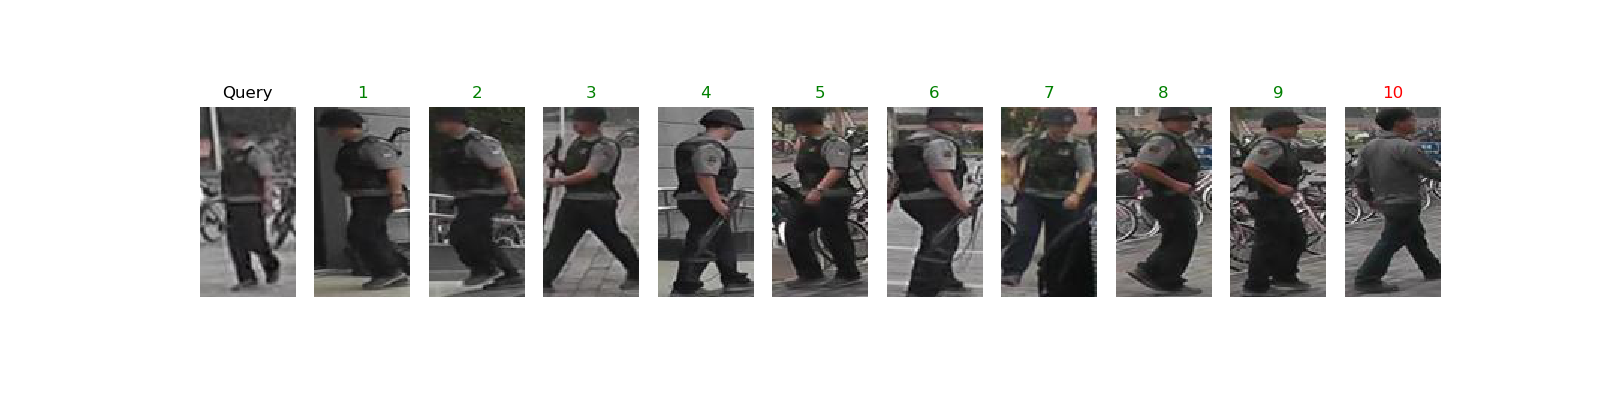

In [7]:
%run apply.py --query_index 888
display(Image.open('result.png'))